# User study simulation

In [8]:
import pandas as pd 
import numpy as np 
from random import sample 
from sklearn.utils import resample  
import scipy
from sklearn import metrics 
from matplotlib import pyplot as plt 
from sklearn.metrics import precision_recall_curve
from graphviz import Digraph

import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
from graphviz import Digraph
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, LinearRegression

# Q1: intuition check

In [9]:
x1 = np.array([0, 1])
x4 = x3 = x2 = x1
 
X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4}).loc[:, ['X1', 'X2', 'X3', 'X4']]
f = lambda x: x[:, 3] # assume x 2d
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), 1)

,X1,X2,X3,X4,f
0,0,0,0,0,0
1,1,1,1,1,1


In [29]:
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=1e-10, single_bg=True)
cf_on_manifold = explainer.shap_values(X.iloc[[1]])

100%|██████████| 1/1 [00:00<00:00, 25.98it/s]


In [21]:
explainer = IndExplainer(f, X.iloc[[0]], nruns=100)
cf_ind = explainer.shap_values(X.iloc[[1]])

100%|██████████| 100/100 [00:00<00:00, 7032.70it/s]


In [30]:
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=1e-10, orderings=[[0, 1, 2, 3]], single_bg=True)
cf_asv = explainer.shap_values(X.iloc[[1]])

100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


In [15]:
causal_links = CausalLinks()
target_name = 'f'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, lambda *args: f(np.vstack(args).T))
causal_links.add_causes_effects('X1', 'X2', lambda x: x)
causal_links.add_causes_effects('X2', 'X3', lambda x: x)
causal_links.add_causes_effects('X3', 'X4', lambda x: x)
causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, target_name=target_name)

cf_flow = GraphExplainer(causal_graph, X.iloc[[0]], nruns=100).shap_values(X.iloc[[1]], rankdir='LR')

0it [00:00, ?it/s]
bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 2099.75it/s]


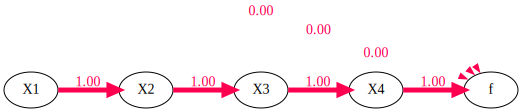

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f97039ffe10>>

In [24]:
cf_flow.draw(0, show_fg_val=False)

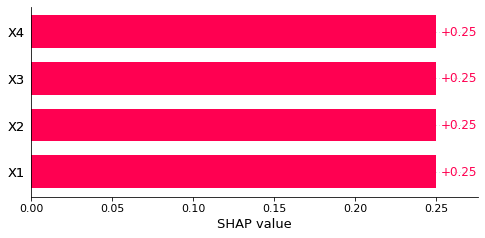

In [31]:
cf_on_manifold.draw(0) # b/c it is a distribution

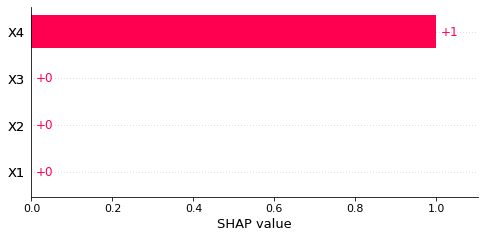

In [22]:
cf_ind.draw(0)

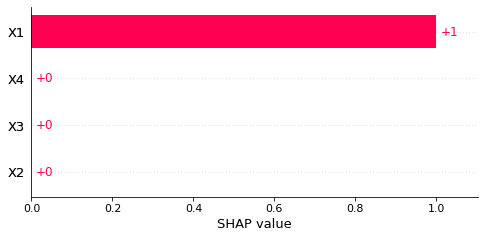

In [32]:
cf_asv.draw(0)

In [ ]:
# simulation: generate fake human response
# assumption: human gives attributions within 0-1 for each edge, therefore errors range from 0-1, we assume MSE is uniform from 0-1
n_users = 100




In [2]:
tests= {0: "no model", 1: "model"}

In [3]:
all_patients = list(np.arange(100))
ground_truth = np.random.choice([0,1], size = (len(all_patients), ), p = [0.5, 0.5])
subset_patients_shown = 8 
total_num_physicians = 250 
physician_sex = np.random.choice([0,1], size = (total_num_physicians, ), p = [0.5, 0.5])
physician_age = np.random.uniform(28,80, size = total_num_physicians)

In [4]:
df = pd.DataFrame(columns = ["clinician", "patient", "test", "chf_prediction", "chf_truth", "age", "sex"])
for seed, physician in enumerate(np.arange(total_num_physicians)):
# pick subset of patients to show 
    np.random.seed(seed)
    patients_shown = sample(all_patients, subset_patients_shown)
# pick set of patients to show with model 
    patients_with_model = sample(patients_shown, 4)
# pick set of patients to show without model 
    patients_without_model = np.setdiff1d(patients_shown, patients_with_model)
    
    for patient in patients_with_model:
        
        gt = ground_truth[patient]
        age = physician_age[physician]
        sex = physician_sex[physician]
#         if age < 50 + model -> 90% accurate 
        if (age < 50):
            if (np.random.choice([0,1], size = (1, ), p = [0.1, 0.9])[0]):
                prediction = ground_truth[patient]
            else:
                prediction = 1-ground_truth[patient]
#         if age >= 50 + model -> 80% accurate 
        else: 
            if (np.random.choice([0,1], size = (1, ), p = [0.2, 0.8])[0]):
                prediction = ground_truth[patient] 
            else:
                prediction =  1-ground_truth[patient]
        df = df.append(pd.Series([physician, patient, 1, prediction, ground_truth[patient], age, sex], index = df.columns), ignore_index = True)
    for patient in patients_without_model:
        
        gt = ground_truth[patient]
        age = physician_age[physician]
        sex = physician_sex[physician]
#         if age < 50 + model -> 70% accurate 
        if (age < 50):
            if (np.random.choice([0,1], size = (1, ), p = [0.3, 0.7])[0]):
                prediction =  ground_truth[patient]
            else:
                prediction =  1-ground_truth[patient]
#         if age >= 50 + model -> 60% accurate 
        else: 
            if (np.random.choice([0,1], size = (1, ), p = [0.4, 0.6])[0]):
                prediction =  ground_truth[patient]
            else:
                prediction =  1-ground_truth[patient]
        df = df.append(pd.Series([physician, patient, 0, prediction, ground_truth[patient], age, sex], index = df.columns), ignore_index = True)
        
        
df["accurate"] = 1 - np.logical_xor(df["chf_prediction"],df["chf_truth"]) 

In [5]:
df

,clinician,patient,test,chf_prediction,chf_truth,age,sex,accurate
0,0.0,54.0,1.0,1.0,1.0,72.344340,1.0,1
1,0.0,15.0,1.0,0.0,0.0,72.344340,1.0,1
2,0.0,93.0,1.0,1.0,1.0,72.344340,1.0,1
3,0.0,78.0,1.0,1.0,1.0,72.344340,1.0,1
4,0.0,35.0,0.0,0.0,0.0,72.344340,1.0,1
...,...,...,...,...,...,...,...,...
1995,249.0,33.0,1.0,1.0,1.0,40.349997,0.0,1
1996,249.0,19.0,0.0,0.0,0.0,40.349997,0.0,1
1997,249.0,22.0,0.0,0.0,0.0,40.349997,0.0,1
1998,249.0,76.0,0.0,0.0,1.0,40.349997,0.0,0
